In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### Step 1. 데이터의 전처리

#### 1.1 Session Length
UserId를 한 세션의 Id라고 가정

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
pd.DataFrame(session_length).describe()

,0
count,6040.000000
mean,165.597517
std,192.747029
min,20.000000
25%,44.000000
50%,96.000000
75%,208.000000
max,2314.000000


In [7]:
print('최솟값:',session_length.min())
print('중간값:',session_length.median())
print('평균:',session_length.mean())
print('최댓값:',session_length.max())

최솟값: 20
중간값: 96.0
평균: 165.5975165562914
최댓값: 2314


In [8]:
session_length.quantile(0.999) # 99.9%의 세션 길이

1343.181000000005

In [9]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [10]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_90 = length_percent_cumsum[length_percent_cumsum < 0.90]

length_percent_cumsum_90

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
395    0.897682
396    0.897848
397    0.898344
398    0.899007
399    0.899834
Length: 376, dtype: float64

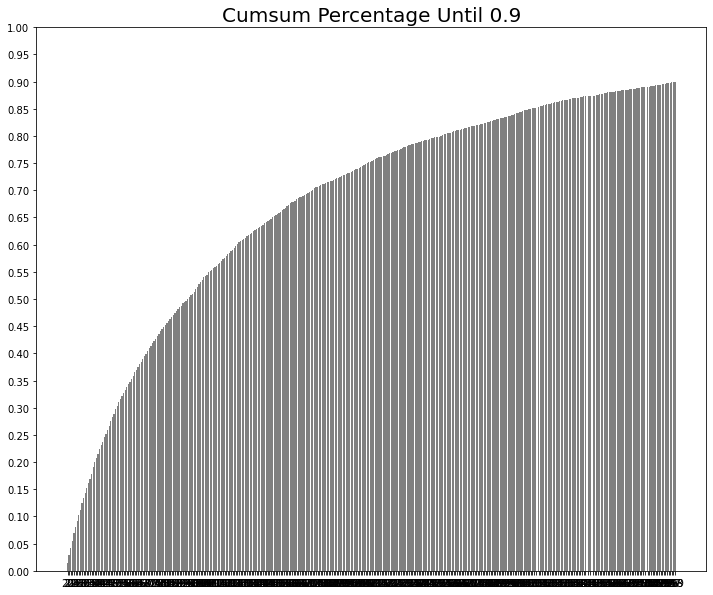

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_90.index,
        height=length_percent_cumsum_90, color='gray')
plt.xticks(length_percent_cumsum_90.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.9', size=20)
plt.show()

#### 1.2 Session Time

In [12]:
data['Time'] = data['Time'].apply(lambda x:dt.datetime.utcfromtimestamp(int(x)))
data['Time']

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [14]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [15]:
# # 최종 날짜로부터 한 달 간의 데이터
# month_ago = latest - dt.timedelta(30)
# data = data[data['Time'] > month_ago]
# data

In [16]:
type(data['Time'])

pandas.core.series.Series

#### 1.3 Data Cleansing

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click, low_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        data = cleanse_low_ratings(data, low_rating)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data


def cleanse_low_ratings(data: pd.DataFrame, low_rating):
    ratings = data.groupby('Rating').size()
    rating_use = ratings[ratings >= low_rating].index
    data = data[data['Rating'].isin(rating_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5, low_rating=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- 상품을 1개만 평가한 유저, 5개 이하로 평가된 영화, 평점이 1점인 영화 제거

#### 1.4 Train / Valid / Test split

In [19]:
# UserId를 기준으로 train, val, test = 0.7, 0.2, 0.1로 분리
tr = data[data['UserId'] <= 4228]
val = data[(data['UserId'] > 4228) & (data['UserId'] <= 5436)]
test = data[data['UserId'] > 5436]

In [20]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [21]:
# tr, test = split_by_date(data, n_days=1)
# tr, val = split_by_date(tr, n_days=1)

In [22]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [23]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 705588
	 Sessions: 4228
	 Items: 3416
	 First Time : 2000-08-03 14:24:25
	 Last Time : 2003-02-28 00:51:39

* valid Set Stats Info
	 Events: 193323
	 Sessions: 1208
	 Items: 3342
	 First Time : 2000-06-03 05:20:31
	 Last Time : 2003-02-28 17:49:50

* test Set Stats Info
	 Events: 100700
	 Sessions: 604
	 Items: 3172
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-28 13:12:12



In [24]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [25]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

#### 2.1 SessionDataset

In [26]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets() # 각 세션이 시작된 인덱스
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [28]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 704344, 705565, 705588], dtype=int32)

In [29]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4225, 4226, 4227])

#### 2.2 SessionDataLoader

In [30]:
class SessionDataLoader: # Session-Parallel mini-batch 만드는 클래스
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self): # 모델 인풋, 라벨, 세션이 끝나는 곳의 위치 yield
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated # RNN Cell State 초기화에 사용
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### Step 3. 모델 구성

#### 3.1 Evaluation Metric

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [37]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (512, 50)                 0         
_________________________________________________________________
dense (Dense)                (512, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

- args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
#### epochs = 3

In [40]:
args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [41]:
train_model(model, args)

Evaluation:  54%|█████▍    | 202/375 [07:06<06:05,  2.11s/it]


	 - Recall@20 epoch 1: 0.106320
	 - MRR@20    epoch 1: 0.024257



Evaluation:  54%|█████▍    | 202/375 [06:44<05:46,  2.00s/it]


	 - Recall@20 epoch 2: 0.203811
	 - MRR@20    epoch 2: 0.051126



Evaluation:  54%|█████▍    | 202/375 [06:32<05:36,  1.94s/it]

	 - Recall@20 epoch 3: 0.250493
	 - MRR@20    epoch 3: 0.064992



### Step 5. 모델 테스트

In [42]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 37/195 [01:11<05:05,  1.93s/it]

	 - Recall@20: 0.264358
	 - MRR@20: 0.069827



> epochs = 3일 때 MRR의 값이 작게 나와 정답 아이템이 후 순위로 추천될 것이다.

- args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
#### epochs = 10

In [43]:
args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [44]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [45]:
train_model(model, args)

Evaluation:  54%|█████▍    | 202/375 [06:27<05:32,  1.92s/it]


	 - Recall@20 epoch 1: 0.273940
	 - MRR@20    epoch 1: 0.072610



Evaluation:  54%|█████▍    | 202/375 [06:21<05:26,  1.89s/it]


	 - Recall@20 epoch 2: 0.288608
	 - MRR@20    epoch 2: 0.078631



Evaluation:  54%|█████▍    | 202/375 [06:18<05:24,  1.87s/it]


	 - Recall@20 epoch 3: 0.296440
	 - MRR@20    epoch 3: 0.082337



Evaluation:  54%|█████▍    | 202/375 [06:14<05:20,  1.85s/it]


	 - Recall@20 epoch 4: 0.302502
	 - MRR@20    epoch 4: 0.085117



Evaluation:  54%|█████▍    | 202/375 [06:12<05:19,  1.85s/it]


	 - Recall@20 epoch 5: 0.306612
	 - MRR@20    epoch 5: 0.087322



Evaluation:  54%|█████▍    | 202/375 [06:10<05:17,  1.84s/it]


	 - Recall@20 epoch 6: 0.309551
	 - MRR@20    epoch 6: 0.089186



Evaluation:  54%|█████▍    | 202/375 [06:11<05:18,  1.84s/it]


	 - Recall@20 epoch 7: 0.312577
	 - MRR@20    epoch 7: 0.090423



Evaluation:  54%|█████▍    | 202/375 [06:12<05:18,  1.84s/it]


	 - Recall@20 epoch 8: 0.314637
	 - MRR@20    epoch 8: 0.091315



Evaluation:  54%|█████▍    | 202/375 [06:12<05:19,  1.85s/it]


	 - Recall@20 epoch 9: 0.315072
	 - MRR@20    epoch 9: 0.091996



Evaluation:  54%|█████▍    | 202/375 [06:12<05:19,  1.85s/it]

	 - Recall@20 epoch 10: 0.315430
	 - MRR@20    epoch 10: 0.092435



In [46]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 37/195 [01:08<04:53,  1.86s/it]

	 - Recall@20: 0.306377
	 - MRR@20: 0.092136



> epochs = 10일 때 MRR의 값이 epochs = 3일 때보다는 크게 나와 조금 개선된 것을 확인할 수 있었다.

- args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
#### epochs를 10으로 유지한 상태에서 batch_size를 256으로 줄였다.

In [47]:
args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [48]:
train_model(model, args)

Evaluation:  54%|█████▍    | 202/375 [06:11<05:18,  1.84s/it]


	 - Recall@20 epoch 1: 0.315681
	 - MRR@20    epoch 1: 0.093011



Evaluation:  54%|█████▍    | 202/375 [06:11<05:18,  1.84s/it]


	 - Recall@20 epoch 2: 0.316339
	 - MRR@20    epoch 2: 0.093723



Evaluation:  54%|█████▍    | 202/375 [06:11<05:18,  1.84s/it]


	 - Recall@20 epoch 3: 0.316619
	 - MRR@20    epoch 3: 0.093959



Evaluation:  54%|█████▍    | 202/375 [06:11<05:17,  1.84s/it]


	 - Recall@20 epoch 4: 0.316696
	 - MRR@20    epoch 4: 0.094284



Evaluation:  54%|█████▍    | 202/375 [06:10<05:17,  1.84s/it]


	 - Recall@20 epoch 5: 0.316397
	 - MRR@20    epoch 5: 0.094566



Evaluation:  54%|█████▍    | 202/375 [06:10<05:16,  1.83s/it]


	 - Recall@20 epoch 6: 0.316348
	 - MRR@20    epoch 6: 0.094888



Evaluation:  54%|█████▍    | 202/375 [06:11<05:18,  1.84s/it]


	 - Recall@20 epoch 7: 0.316542
	 - MRR@20    epoch 7: 0.094917



Evaluation:  54%|█████▍    | 202/375 [06:12<05:19,  1.85s/it]


	 - Recall@20 epoch 8: 0.316348
	 - MRR@20    epoch 8: 0.094814



Evaluation:  54%|█████▍    | 202/375 [06:13<05:19,  1.85s/it]


	 - Recall@20 epoch 9: 0.316445
	 - MRR@20    epoch 9: 0.094921



Evaluation:  54%|█████▍    | 202/375 [06:12<05:19,  1.84s/it]

	 - Recall@20 epoch 10: 0.315913
	 - MRR@20    epoch 10: 0.095030



In [49]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 37/195 [01:08<04:51,  1.84s/it]

	 - Recall@20: 0.309861
	 - MRR@20: 0.092344



> batch_size를 조정한 결과 recall의 값은 줄었으나 MRR의 값은 조금 올라 이전보다는 성능이 개선된 것으로 보인다.

### 회고

- 영화 평점 데이터를 가지고 세션 기반 추천 시스템을 만들다 보니 평점을 낮게 부여한 영화들은 제외하는 것이 낫겠다고 판단해서 데이터 정제 과정에서 제거하고 모델 학습을 진행하였다.
- 데이터를 나누었을 때 Index Error가 나와서 여려움을 겪었다. 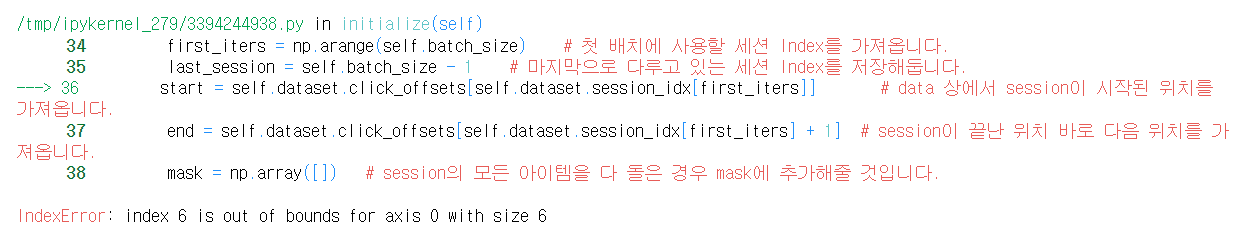 최신 데이터인 최근 30일 간의 데이터 대신, 전체 데이터를 기준으로 모델학습을 진행하니 Index Error 없이 진행이 되었다. 어떤 부분에서 Index Error가 나왔는지 알고 싶었으나 쉽지 않았다.
- 모델 학습을 시켰을 때 Train, Evalation 진행 진척 그래프가 완전히 채워지지 않았는데 그 이유가 궁금하다.
- 모델 학습 이후에 추천의 결과로 어떤 영화를 추천해주는지 궁금하고, 영화 추천 결과를 보면 모델이 잘 구성되었는지 시각적으로도 확인 할 수 있을 것 같아 아쉽다.